<a href="https://colab.research.google.com/github/AmericaNC/Alumno/blob/main/RedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RNN: Predictor**

RNN (red neuronal recurrente) con arquitectura LSTM (Long Short-Term Memory), diseñada para capturar patrones temporales en la interacción del usuario con la aplicación.

La red recibe como entrada secuencias de 7 días consecutivos, donde cada día está representado por:

*   Estado emocional promedio del usuario ***avg_emocion***
*   Nivel de adherencia farmacológica ***adherencia***
*   Indicadores de inactividad ***dias_inactivos***






Primero se realiza la instalacion de las herraientas de IA con las que se trabajara la red neuronal.




In [ ]:
!pip install tensorflow pandas numpy scikit-learn


Se realiza la instalacion de dependencias de firebase-admin para poder hacer operaciones de consulta. Es necesario tener y cargar llave de escritura en la seccion de archivos en este punto.

In [ ]:
!pip install firebase-admin


Se importa firebase-admin despues de descargarlo, ademas de inicializar el cliente y cargar la llave.

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("/content/serviceAccountKey.json")
firebase_admin.initialize_app(cred)

db = firestore.client()


Funcion **get** para obtener todos los datos de la coleccion usuarios

In [ ]:
def get_users():
    users_ref = db.collection("Usuarios")
    users = {}

    for doc in users_ref.stream():
        users[doc.id] = doc.to_dict()

    return users


In [ ]:
users = get_users()
print("Usuarios encontrados:", len(users))


Usuarios encontrados: 6


Funcion **get** para obtener todos los datos de la coleccion seguimiento

In [ ]:
def get_seguimiento(user_id):
    eventos = []

    fechas = (
        db.collection("Usuarios")
        .document(user_id)
        .collection("Seguimiento")
        .stream()
    )

    for fecha_doc in fechas:
        fecha = fecha_doc.id

        eventos_ref = fecha_doc.reference.collection("Eventos").stream()
        for ev in eventos_ref:
            data = ev.to_dict()
            data["fecha"] = fecha
            eventos.append(data)

    return eventos


Funcion **get** para obtener todos los datos de la coleccion TomasDiarias

In [ ]:
def get_tomas(user_id):
    tomas = []

    docs = (
        db.collection("Usuarios")
        .document(user_id)
        .collection("TomasDiarias")
        .stream()
    )

    for doc in docs:
        data = doc.to_dict()
        data["fecha"] = doc.id
        tomas.append(data)

    return tomas


Asignacion de valores basica para las emociones.

In [ ]:
EMOCIONES = {
    "Contento": 1.0,
    "Tranquilo": 0.8,
    "Ansioso": 0.3,
    "Avergonzado": 0.2,
    "Triste": 0.1
}


Importar elementos para las funciones, modelo y mantenimiento.

In [ ]:
import numpy as np
import pandas as pd


Prearacion de los datos para utilizarlo en LSTM posteriormente

In [ ]:
def build_daily_rows(eventos, tomas):
    rows = {}

    # Procesar tomas
    for t in tomas:
        fecha = t["fecha"]
        rows.setdefault(fecha, {
            "toma": 0,
            "activo": 0,
            "emocion": 0.5
        })

        # Si hay al menos una toma marcada como tomada
        if "tomas" in t:
            for hora in t["tomas"].values():
                if hora.get("tomado"):
                    rows[fecha]["toma"] = 1

    # Procesar eventos (actividad / emoción)
    for e in eventos:
        fecha = e["fecha"]
        rows.setdefault(fecha, {
            "toma": 0,
            "activo": 0,
            "emocion": 0.5
        })

        rows[fecha]["activo"] = 1

        if e.get("categoria") == "Estigma":
            val = EMOCIONES.get(e.get("respuesta"))
            if val is not None:
                rows[fecha]["emocion"] = val

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index = pd.to_datetime(df.index)
    return df.sort_index()


Conversion de los datos anteriores en secuencias LSTM para la construccion de la red neuronal.

In [ ]:
def build_sequences(df, window=7):
    X = []
    y = []

    for i in range(len(df) - window):
        seq = df.iloc[i:i+window][["toma", "activo", "emocion"]].values
        X.append(seq)

        # etiqueta: abandono si en los siguientes 7 días no hay tomas
        future = df.iloc[i+window:i+window+7]["toma"].sum()
        y.append(1 if future == 0 else 0)

    return np.array(X), np.array(y)


Construccion de dataset completo, en caso de entrenar con un dataset mas grande, en esta parte es en donde se podrian hacer grandes modelos y cargarlos.

In [ ]:
import numpy as np

X_all = []
y_all = []

for user_id in users.keys():
    eventos = get_seguimiento(user_id)
    tomas = get_tomas(user_id)

    df_days = build_daily_rows(eventos, tomas)

    if len(df_days) < 14:
        continue

    X, y = build_sequences(df_days)

    if len(X) > 0:
        X_all.append(X)
        y_all.append(y)

X = np.concatenate(X_all)
y = np.concatenate(y_all)

print("X:", X.shape)
print("y:", y.shape)


X: (31, 7, 3)
y: (31,)


Comienza el entrenamiento de la red neuronal.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(24, 7, 3) (7, 7, 3)


El modelo se construye, consolida y se compila

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
model = Sequential([
    LSTM(32, input_shape=(7, 3), return_sequences=False),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo.

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=16,
    verbose=1
)


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.3056 - loss: 0.7036 - val_accuracy: 0.0000e+00 - val_loss: 0.6946
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4306 - loss: 0.6946 - val_accuracy: 1.0000 - val_loss: 0.6867
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6458 - loss: 0.6891 - val_accuracy: 1.0000 - val_loss: 0.6793
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9028 - loss: 0.6807 - val_accuracy: 1.0000 - val_loss: 0.6741
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.6726 - val_accuracy: 1.0000 - val_loss: 0.6683
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.6629 - val_accuracy: 1.0000 - val_loss: 0.6597
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.6541 - val_accuracy: 1.0000 - val_loss: 0.6502
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.6516 - val_accuracy: 1.0000 - val_loss: 0.

Despliegue de resultados.

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy test: {acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.2682
Accuracy test: 100.00%


In [ ]:
ejemplo = X_test[0:1]

prob = model.predict(ejemplo)[0][0]

print(f"Probabilidad de abandono: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Probabilidad de abandono: 76.48%


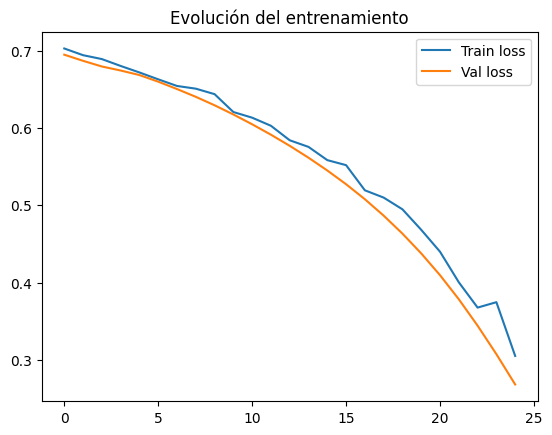

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.legend()
plt.title("Evolución del entrenamiento")
plt.show()